# Rapport de projet : Planification du raccordement électrique

## 1. Contexte
Une tempête a endommagé les infrastructures électriques de la ville.  
L’objectif est de planifier le raccordement optimal des bâtiments pour minimiser les coûts.


## Importation

In [7]:
# Import des bibliothèques nécessaires
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import os
import matplotlib.patches as mpatches
import seaborn as sns
from matplotlib.lines import Line2D
import glob


# Désactiver les avertissements inutiles
import warnings
warnings.filterwarnings("ignore")

# Définir le chemin du dossier de données
data_path = "../data/"  # adapte si besoin
output_path = "../outputs/"

#  Charger les shapefiles des bâtiments et des infrastructures
batiments = gpd.read_file(data_path + "batiments.shp")
infrastructures = gpd.read_file(data_path + "infrastructures.shp")

#  Charger les fichiers Excels du réseau
reseau = pd.read_excel(data_path + "reseau_en_arbre.xlsx")
batiments_aj= pd.read_csv(data_path + "batiments.csv")
infra= pd.read_csv(data_path + "infra.csv")

# ========================
#  Aperçu rapide
# ========================
print("=== Aperçu des données ===")
print("Bâtiments shapefile :", len(batiments))
print("Infrastructures shapefile :", len(infrastructures))
print("Réseau :", len(reseau))
print("Bâtiments ajoutés :", len(batiments_aj))
print("Infrastructures ajoutées :", len(infra))
print("\nColonnes du réseau :", reseau.columns.tolist())

# Affichage rapide
display(batiments.head())
display(infrastructures.head())
display(reseau.head())
display(batiments_aj.head())
display(infra.head())


=== Aperçu des données ===
Bâtiments shapefile : 381
Infrastructures shapefile : 644
Réseau : 6107
Bâtiments ajoutés : 381
Infrastructures ajoutées : 644

Colonnes du réseau : ['id_batiment', 'nb_maisons', 'infra_id', 'infra_type', 'longueur']


,id_bat,nb_maisons,geometry
0,E000270,1.0,POINT (531436.652 259655.507)
1,E000010,1.0,POINT (531445.663 259480.504)
2,E000060,1.0,POINT (531529.658 259588.506)
3,E000200,1.0,POINT (531217.642 259637.504)
4,E000249,1.0,POINT (531369.649 259611.505)


,infra_id,longueur,geometry
0,P007320,5.495148,"LINESTRING (531440.661 259482.497, 531436.99 2..."
1,P000352,3.332987,"LINESTRING (531433.814 259487.594, 531436.99 2..."
2,P007286,7.275098,"LINESTRING (531438.662 259479.506, 531436.99 2..."
3,P007115,10.593967,"LINESTRING (531445.663 259480.504, 531436.99 2..."
4,P007321,12.814338,"LINESTRING (531447.665 259479.5, 531436.99 259..."


,id_batiment,nb_maisons,infra_id,infra_type,longueur
0,E000001,4,P007111,infra_intacte,12.314461
1,E000001,4,P007983,infra_intacte,40.320929
2,E000001,4,P000308,infra_intacte,39.140799
3,E000001,4,P007819,infra_intacte,17.390464
4,E000002,1,P007111,infra_intacte,12.314461


,id_batiment,type_batiment,nb_maisons
0,E000160,habitation,8
1,E000367,habitation,3
2,E000032,habitation,1
3,E000017,habitation,7
4,E000339,habitation,1


,id_infra,type_infra
0,P000719,aerien
1,P007118,aerien
2,P007170,fourreau
3,P007648,aerien
4,P000306,aerien


## Fusion

In [ ]:
# =============================
# 1 Fusion des bâtiments : shapefile + CSV
# =============================

# Vérifions d'abord que les colonnes existent bien
print("Colonnes du shapefile :", batiments.columns.tolist())
print("Colonnes du CSV :", batiments_aj.columns.tolist())

# On sélectionne uniquement les colonnes utiles du CSV
colonnes_batiments_aj = ["id_batiment", "nb_maisons", "type_batiment"]

# Fusion sur les clés correspondantes : id_bat (SHP) et id_batiment (CSV)
batiments_fusion = batiments.merge(
    batiments_aj[colonnes_batiments_aj],
    left_on="id_bat",
    right_on="id_batiment",
    how="left"
)

# Remplacer nb_maisons du SHP par celle du CSV si elle existe
if "nb_maisons_y" in batiments_fusion.columns:
    batiments_fusion["nb_maisons"] = batiments_fusion["nb_maisons_y"].combine_first(batiments_fusion["nb_maisons_x"])
    batiments_fusion = batiments_fusion.drop(columns=["nb_maisons_x", "nb_maisons_y"])

# Supprimer la colonne de jointure inutile
if "id_batiment" in batiments_fusion.columns:
    batiments_fusion = batiments_fusion.drop(columns=["id_batiment"])

# Vérifions le résultat
print("\n✅ Fusion terminée avec succès !")
print("Nombre d’enregistrements :", len(batiments_fusion))
print("Colonnes finales :", batiments_fusion.columns.tolist())

# Aperçu des premières lignes
display(batiments_fusion.head())


# =============================
# 2️ Fusion du réseau (Excel) avec infra (CSV)
# =============================

# Vérifions d'abord les colonnes disponibles
print("Colonnes du réseau :", reseau.columns.tolist())
print("Colonnes du CSV infra :", infra.columns.tolist())

# Fusionner en ajoutant le type d’infrastructure depuis le CSV
reseau_fusion = reseau.merge(
    infra[["id_infra", "type_infra"]],
    left_on="infra_id",   # colonne dans Excel
    right_on="id_infra",  # colonne dans CSV
    how="left"            # on garde tout le réseau
)

# Supprimer la colonne de jointure inutile
reseau_fusion = reseau_fusion.drop(columns=["id_infra"], errors="ignore")

# Vérifier le résultat
print("\n✅ Fusion réussie !")
print("Nombre de lignes :", len(reseau_fusion))
print("Colonnes finales :", reseau_fusion.columns.tolist())

display(reseau_fusion.head())


# =============================
# 3️ Création des indicateurs prix et durée
# =============================

# Définir les dictionnaires de correspondance
prix_par_type = {
    "aerien": 500,
    "semi-aerien": 750,
    "fourreau": 900
}

duree_par_type = {
    "aerien": 2,
    "semi-aerien": 4,
    "fourreau": 5
}

# Appliquer les correspondances
reseau_fusion["prix_metre"] = reseau_fusion["type_infra"].map(prix_par_type)
reseau_fusion["duree_heure_metre"] = reseau_fusion["type_infra"].map(duree_par_type)

# Calculer les prix et durées totaux pour chaque ligne
reseau_fusion["prix_total (€)"] = reseau_fusion["prix_metre"] * reseau_fusion["longueur"]
reseau_fusion["duree_totale (h)"] = reseau_fusion["duree_heure_metre"] * reseau_fusion["longueur"]

# Afficher un aperçu des résultats
print("\n=== Indicateurs calculés ===")
display(reseau_fusion.head())

# =============================
# 4 Fusion géospatiale propre : Infrastructures + Réseau enrichi
# =============================

# Vérifier les colonnes avant fusion
print("Colonnes du shapefile infrastructures :", infrastructures.columns.tolist())
print("Colonnes du tableau réseau fusionné :", reseau_fusion.columns.tolist())

# Faire la fusion
infra_fusion = infrastructures.merge(
    reseau_fusion,
    on="infra_id",
    how="left"
)

# Si on a deux colonnes longueur (longueur_x, longueur_y)
if "longueur_x" in infra_fusion.columns and "longueur_y" in infra_fusion.columns:
    # On garde la version du réseau (souvent plus précise)
    infra_fusion["longueur"] = infra_fusion["longueur_y"].combine_first(infra_fusion["longueur_x"])
    # On supprime les anciennes
    infra_fusion = infra_fusion.drop(columns=["longueur_x", "longueur_y"])

# Vérification du résultat final
print("\n✅ Fusion géospatiale réussie et nettoyée !")
print("Nombre d’enregistrements :", len(infra_fusion))
print("Colonnes finales :", infra_fusion.columns.tolist())

# Aperçu des données principales
display(infra_fusion.head())


# =============================
# 5️ Fusion finale : infra_fusion + batiments_aj
# =============================
# Vérifions les colonnes disponibles
print("Colonnes de infra_fusion :", infra_fusion.columns.tolist())
print("Colonnes de batiments_aj :", batiments_aj.columns.tolist())

# -----------------------------
# Fusion sur la clé 'id_batiment'
# On garde toutes les infrastructures enrichies et ajoute type_batiment
Data_final = infra_fusion.merge(
    batiments_aj[["id_batiment", "type_batiment", "nb_maisons"]],  # inclut nb_maisons
    on="id_batiment",
    how="left",
    suffixes=('', '_new')  # pour éviter conflit avec nb_maisons existant
)

# -----------------------------
# Remplacer nb_maisons par la valeur du CSV
Data_final["nb_maisons"] = Data_final["nb_maisons_new"]
Data_final = Data_final.drop(columns=["nb_maisons_new"])

# Vérification du résultat
print("\n✅ Fusion finale et mise à jour de nb_maisons réussies !")
print("Nombre d’enregistrements :", len(Data_final))
print("Colonnes finales :", Data_final.columns.tolist())

# Aperçu rapide
display(Data_final.head())


# Créer une version tabulaire sans la colonne geometry
Data_final_tab = Data_final.drop(columns="geometry", errors="ignore")

# Définir le nom du fichier de sortie
output_file = os.path.join(output_path, "Dats_final.xlsx")

# Exporter en Excel
Data_final_tab.to_excel(output_file, index=False)

print(f"\n📁 Fichier exporté avec succès : {output_file}")



Colonnes du shapefile : ['id_bat', 'nb_maisons', 'geometry']
Colonnes du CSV : ['id_batiment', 'type_batiment', 'nb_maisons']

✅ Fusion terminée avec succès !
Nombre d’enregistrements : 381
Colonnes finales : ['id_bat', 'geometry', 'type_batiment', 'nb_maisons']


,id_bat,geometry,type_batiment,nb_maisons
0,E000270,POINT (531436.652 259655.507),habitation,6
1,E000010,POINT (531445.663 259480.504),habitation,5
2,E000060,POINT (531529.658 259588.506),habitation,4
3,E000200,POINT (531217.642 259637.504),habitation,8
4,E000249,POINT (531369.649 259611.505),habitation,2


Colonnes du réseau : ['id_batiment', 'nb_maisons', 'infra_id', 'infra_type', 'longueur']
Colonnes du CSV infra : ['id_infra', 'type_infra']

✅ Fusion réussie !
Nombre de lignes : 6107
Colonnes finales : ['id_batiment', 'nb_maisons', 'infra_id', 'infra_type', 'longueur', 'type_infra']


,id_batiment,nb_maisons,infra_id,infra_type,longueur,type_infra
0,E000001,4,P007111,infra_intacte,12.314461,fourreau
1,E000001,4,P007983,infra_intacte,40.320929,aerien
2,E000001,4,P000308,infra_intacte,39.140799,fourreau
3,E000001,4,P007819,infra_intacte,17.390464,fourreau
4,E000002,1,P007111,infra_intacte,12.314461,fourreau



=== Indicateurs calculés ===


,id_batiment,nb_maisons,infra_id,infra_type,longueur,type_infra,prix_metre,duree_heure_metre,prix_total (€),duree_totale (h)
0,E000001,4,P007111,infra_intacte,12.314461,fourreau,900,5,11083.015202,61.572307
1,E000001,4,P007983,infra_intacte,40.320929,aerien,500,2,20160.464433,80.641858
2,E000001,4,P000308,infra_intacte,39.140799,fourreau,900,5,35226.718710,195.703993
3,E000001,4,P007819,infra_intacte,17.390464,fourreau,900,5,15651.417892,86.952322
4,E000002,1,P007111,infra_intacte,12.314461,fourreau,900,5,11083.015202,61.572307


Colonnes du shapefile infrastructures : ['infra_id', 'longueur', 'geometry']
Colonnes du tableau réseau fusionné : ['id_batiment', 'nb_maisons', 'infra_id', 'infra_type', 'longueur', 'type_infra', 'prix_metre', 'duree_heure_metre', 'prix_total (€)', 'duree_totale (h)']

✅ Fusion géospatiale réussie et nettoyée !
Nombre d’enregistrements : 6107
Colonnes finales : ['infra_id', 'geometry', 'id_batiment', 'nb_maisons', 'infra_type', 'type_infra', 'prix_metre', 'duree_heure_metre', 'prix_total (€)', 'duree_totale (h)', 'longueur']


,infra_id,geometry,id_batiment,nb_maisons,infra_type,type_infra,prix_metre,duree_heure_metre,prix_total (€),duree_totale (h),longueur
0,P007320,"LINESTRING (531440.661 259482.497, 531436.99 2...",E000008,1,infra_intacte,fourreau,900,5,4945.63319,27.475740,5.495148
1,P000352,"LINESTRING (531433.814 259487.594, 531436.99 2...",E000008,1,infra_intacte,aerien,500,2,1666.49331,6.665973,3.332987
2,P000352,"LINESTRING (531433.814 259487.594, 531436.99 2...",E000009,1,infra_intacte,aerien,500,2,1666.49331,6.665973,3.332987
3,P000352,"LINESTRING (531433.814 259487.594, 531436.99 2...",E000010,1,infra_intacte,aerien,500,2,1666.49331,6.665973,3.332987
4,P000352,"LINESTRING (531433.814 259487.594, 531436.99 2...",E000011,1,infra_intacte,aerien,500,2,1666.49331,6.665973,3.332987


Colonnes de infra_fusion : ['infra_id', 'geometry', 'id_batiment', 'nb_maisons', 'infra_type', 'type_infra', 'prix_metre', 'duree_heure_metre', 'prix_total (€)', 'duree_totale (h)', 'longueur']
Colonnes de batiments_aj : ['id_batiment', 'type_batiment', 'nb_maisons']

✅ Fusion finale et mise à jour de nb_maisons réussies !
Nombre d’enregistrements : 6107
Colonnes finales : ['infra_id', 'geometry', 'id_batiment', 'nb_maisons', 'infra_type', 'type_infra', 'prix_metre', 'duree_heure_metre', 'prix_total (€)', 'duree_totale (h)', 'longueur', 'type_batiment']


,infra_id,geometry,id_batiment,nb_maisons,infra_type,type_infra,prix_metre,duree_heure_metre,prix_total (€),duree_totale (h),longueur,type_batiment
0,P007320,"LINESTRING (531440.661 259482.497, 531436.99 2...",E000008,6,infra_intacte,fourreau,900,5,4945.63319,27.475740,5.495148,habitation
1,P000352,"LINESTRING (531433.814 259487.594, 531436.99 2...",E000008,6,infra_intacte,aerien,500,2,1666.49331,6.665973,3.332987,habitation
2,P000352,"LINESTRING (531433.814 259487.594, 531436.99 2...",E000009,2,infra_intacte,aerien,500,2,1666.49331,6.665973,3.332987,habitation
3,P000352,"LINESTRING (531433.814 259487.594, 531436.99 2...",E000010,5,infra_intacte,aerien,500,2,1666.49331,6.665973,3.332987,habitation
4,P000352,"LINESTRING (531433.814 259487.594, 531436.99 2...",E000011,8,infra_intacte,aerien,500,2,1666.49331,6.665973,3.332987,habitation


PermissionError: [Errno 13] Permission denied: '../outputs/infrastructures_finales.xlsx'

## Visualisation des données 

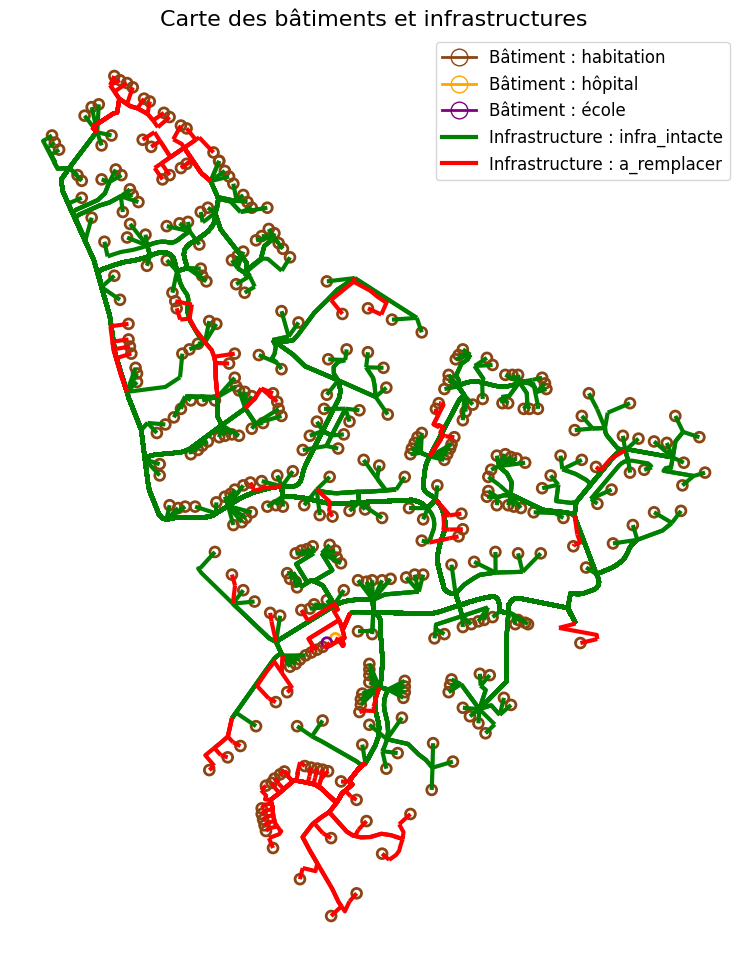

In [30]:


# Créer la figure
fig, ax = plt.subplots(figsize=(12, 12))

# --- Couleurs pour les bâtiments ---
couleurs_bat = ["saddlebrown", "orange", "purple"]
types_bat = batiments_fusion["type_batiment"].dropna().unique()
batiment_color_map = dict(zip(types_bat, couleurs_bat[:len(types_bat)]))

# Plot bâtiments (cercles vides)
for t in types_bat:
    batiments_fusion[batiments_fusion["type_batiment"] == t].plot(
        ax=ax,
        marker='o',
        facecolor='none',            # cercle vide
        edgecolor=batiment_color_map[t],
        linewidth=2,
        markersize=50
    )

# --- Couleurs pour les infrastructures ---
couleurs_infra = ["green", "red"]
types_infra = infra_fusion["infra_type"].dropna().unique()
infra_color_map = dict(zip(types_infra, couleurs_infra[:len(types_infra)]))

# Plot infrastructures (lignes)
for t in types_infra:
    infra_fusion[infra_fusion["infra_type"] == t].plot(
        ax=ax,
        color=infra_color_map[t],
        linewidth=3
    )

# --- Légende personnalisée ---
handles = []

# Bâtiments : cercle vide
for t in types_bat:
    handles.append(Line2D([0], [0], marker='o', color=batiment_color_map[t],
                          markerfacecolor='none', markersize=12, linewidth=2,
                          label=f"Bâtiment : {t}"))

# Infrastructures : ligne
for t in types_infra:
    handles.append(Line2D([0], [0], color=infra_color_map[t], linewidth=3,
                          label=f"Infrastructure : {t}"))

# Ajouter la légende
plt.legend(handles=handles, loc='best', fontsize=12)

# Titre
plt.title("Carte des bâtiments et infrastructures", fontsize=16)
plt.axis('off')

# Afficher
plt.show()


## Analyse primaire Sur le dataframe final après les fusions

Taille initiale : (5586, 12)
Après nettoyage : (5586, 12)

🏠 **Analyse du Bâti**

Statistiques par type de bâtiment :
              nb_maisons             prix_total (€)                    \
                    mean   sum count           mean         sum count   
type_batiment                                                           
habitation          4.39  1665   379        5910.59  2240114.37   379   
hôpital             1.00     1     1        3094.67     3094.67     1   
école               1.00     1     1        3094.67     3094.67     1   

              duree_totale (h)                  
                          mean       sum count  
type_batiment                                   
habitation               28.75  10896.84   379  
hôpital                  12.38     12.38     1  
école                    12.38     12.38     1  

💰 Top 10 bâtiments les plus coûteux :
    id_batiment type_batiment  prix_total (€)  duree_totale (h)
330     E000012    habitation    68383.795652 

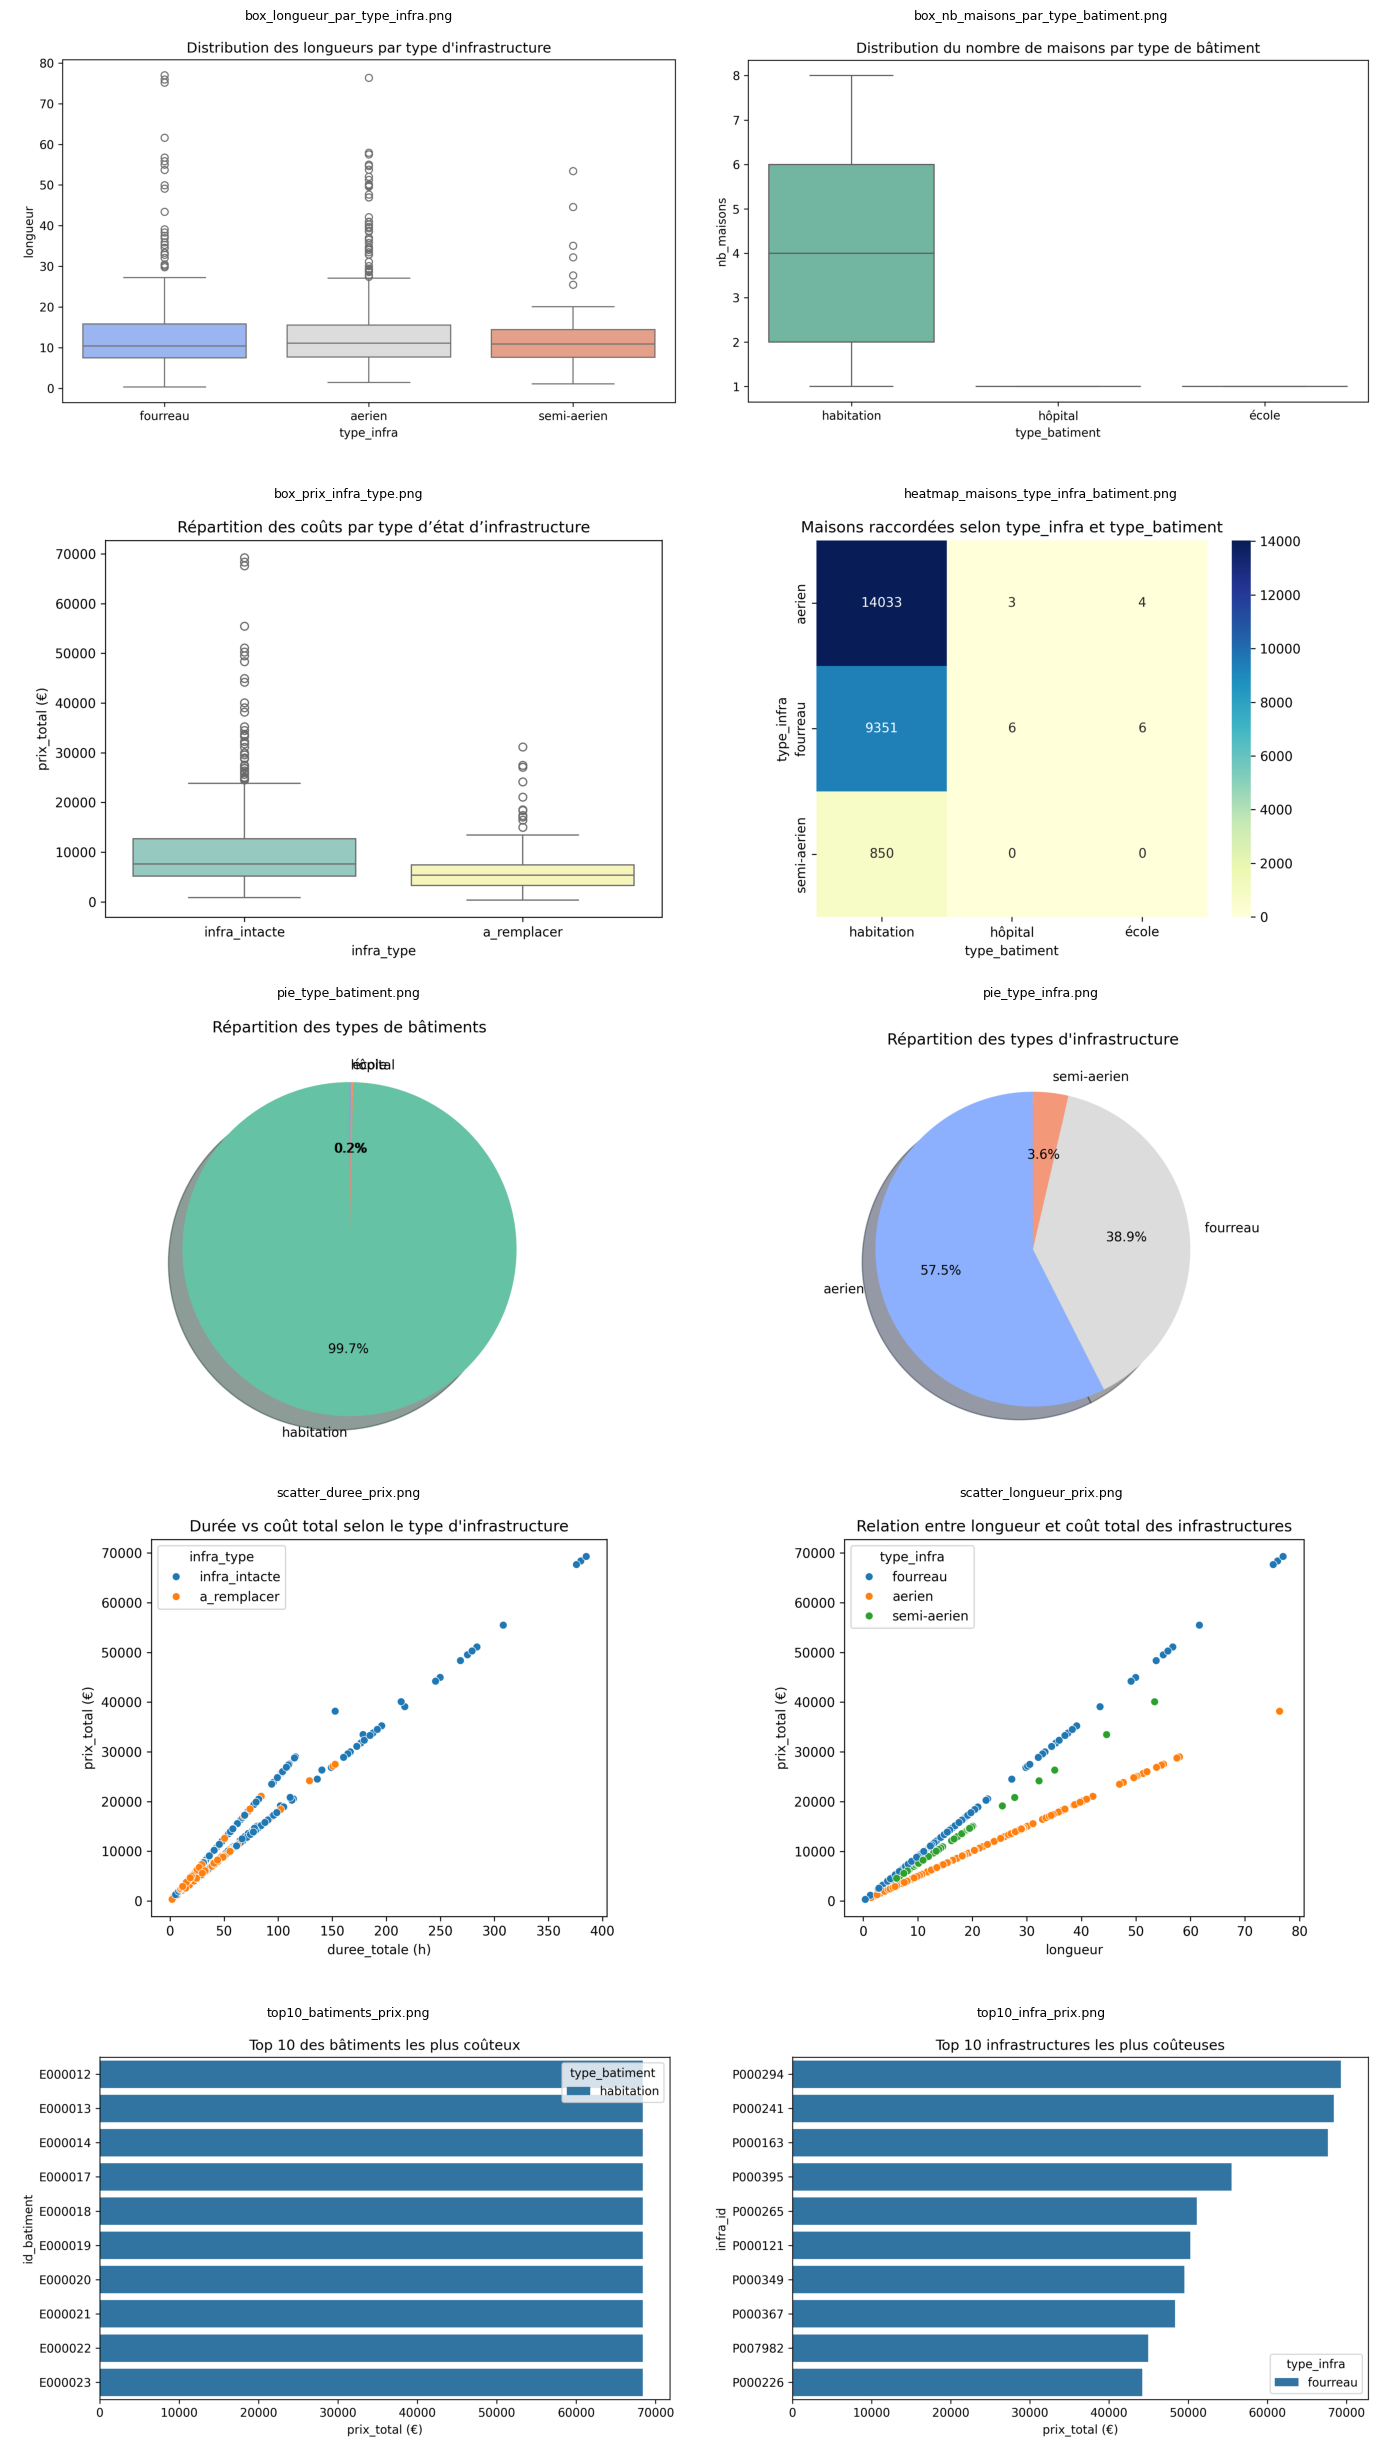


✅ Tous les graphiques et analyses ont été enregistrés dans : C:\Users\AHassak\Desktop\HETIC\Refresher _ Optimisation Opérationnelle\Planification-du-raccordement-lectrique-de-b-timents\raccordement-electrique\outputs
🧾 Rapport visuel complet prêt à interprétation.


In [10]:
import matplotlib.image as mpimg


#  Répertoire de sortie
output_path = r"C:\Users\AHassak\Desktop\HETIC\Refresher _ Optimisation Opérationnelle\Planification-du-raccordement-lectrique-de-b-timents\raccordement-electrique\outputs"
os.makedirs(output_path, exist_ok=True)

#  Vérification de base
print("Taille initiale :", Data_final.shape)

# ============================================
# 1️ NETTOYAGE & STRUCTURATION
# ============================================

# Supprimer doublons sur (infra_id, id_batiment)
Data_final = Data_final.drop_duplicates(subset=["infra_id", "id_batiment"], keep="first")

# Conversion des variables numériques
num_cols = ["nb_maisons", "prix_metre", "duree_heure_metre", "prix_total (€)", "duree_totale (h)", "longueur"]
for col in num_cols:
    Data_final[col] = pd.to_numeric(Data_final[col], errors="coerce")

print("Après nettoyage :", Data_final.shape)

# ============================================
# 2️ ANALYSE DU BÂTI
# ============================================
print("\n🏠 **Analyse du Bâti**")

batiments_df = Data_final.drop_duplicates(subset=["id_batiment"])

# ➤ Statistiques globales
b_stats = batiments_df.groupby("type_batiment")[["nb_maisons", "prix_total (€)", "duree_totale (h)"]].agg(["mean", "sum", "count"]).round(2)
print("\nStatistiques par type de bâtiment :")
print(b_stats)

# ➤ Boxplot : nb maisons / type bâtiment
plt.figure(figsize=(8,5))
sns.boxplot(data=batiments_df, x="type_batiment", y="nb_maisons", palette="Set2")
plt.title("Distribution du nombre de maisons par type de bâtiment")
plt.tight_layout()
plt.savefig(os.path.join(output_path, "box_nb_maisons_par_type_batiment.png"), dpi=300)
plt.close()

# ➤ Top 10 bâtiments les plus coûteux
top_bati = batiments_df.nlargest(10, "prix_total (€)")[["id_batiment", "type_batiment", "prix_total (€)", "duree_totale (h)"]]
print("\n💰 Top 10 bâtiments les plus coûteux :")
print(top_bati)

plt.figure(figsize=(8,5))
sns.barplot(data=top_bati, x="prix_total (€)", y="id_batiment", hue="type_batiment", dodge=False)
plt.title("Top 10 des bâtiments les plus coûteux")
plt.tight_layout()
plt.savefig(os.path.join(output_path, "top10_batiments_prix.png"), dpi=300)
plt.close()

# ============================================
# 3️ ANALYSE DES INFRASTRUCTURES
# ============================================
print("\n⚙️ **Analyse des Infrastructures**")

infra_df = Data_final.drop_duplicates(subset=["infra_id"])

infra_stats = infra_df.groupby(["infra_type", "type_infra"])[["prix_total (€)", "longueur", "duree_totale (h)"]].agg(["mean", "sum", "count"]).round(2)
print("\nStatistiques par type d’infrastructure :")
print(infra_stats)

#  Boxplot : longueur / type_infra
plt.figure(figsize=(8,5))
sns.boxplot(data=infra_df, x="type_infra", y="longueur", palette="coolwarm")
plt.title("Distribution des longueurs par type d'infrastructure")
plt.tight_layout()
plt.savefig(os.path.join(output_path, "box_longueur_par_type_infra.png"), dpi=300)
plt.close()

#  Top 10 infrastructures les plus coûteuses
top_infra = infra_df.nlargest(10, "prix_total (€)")[["infra_id", "type_infra", "infra_type", "prix_total (€)", "longueur"]]
print("\n🏗️ Top 10 infrastructures les plus coûteuses :")
print(top_infra)

plt.figure(figsize=(8,5))
sns.barplot(data=top_infra, x="prix_total (€)", y="infra_id", hue="type_infra", dodge=False)
plt.title("Top 10 infrastructures les plus coûteuses")
plt.tight_layout()
plt.savefig(os.path.join(output_path, "top10_infra_prix.png"), dpi=300)
plt.close()

# ============================================
# 4️ CROISEMENTS & DISTRIBUTIONS
# ============================================
print("\n🔀 **Analyses croisées et distributions**")

# ➤ Longueur vs coût
plt.figure(figsize=(6,5))
sns.scatterplot(data=infra_df, x="longueur", y="prix_total (€)", hue="type_infra")
plt.title("Relation entre longueur et coût total des infrastructures")
plt.tight_layout()
plt.savefig(os.path.join(output_path, "scatter_longueur_prix.png"), dpi=300)
plt.close()

# ➤ Durée vs coût
plt.figure(figsize=(6,5))
sns.scatterplot(data=infra_df, x="duree_totale (h)", y="prix_total (€)", hue="infra_type")
plt.title("Durée vs coût total selon le type d'infrastructure")
plt.tight_layout()
plt.savefig(os.path.join(output_path, "scatter_duree_prix.png"), dpi=300)
plt.close()

# ➤ Boxplot comparatif des coûts
plt.figure(figsize=(7,5))
sns.boxplot(data=infra_df, x="infra_type", y="prix_total (€)", palette="Set3")
plt.title("Répartition des coûts par type d’état d’infrastructure")
plt.tight_layout()
plt.savefig(os.path.join(output_path, "box_prix_infra_type.png"), dpi=300)
plt.close()

# ➤ Heatmap : type_infra × type_batiment
cross = pd.crosstab(Data_final["type_infra"], Data_final["type_batiment"], values=Data_final["nb_maisons"], aggfunc="sum").fillna(0)
print("\n📊 Nombre total de maisons par type_infra et type_batiment :")
print(cross)

plt.figure(figsize=(6,5))
sns.heatmap(cross, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title("Maisons raccordées selon type_infra et type_batiment")
plt.tight_layout()
plt.savefig(os.path.join(output_path, "heatmap_maisons_type_infra_batiment.png"), dpi=300)
plt.close()

# ============================================
# 5️ PIE CHARTS : Répartition des types
# ============================================
print("\n🥧 **Camemberts de répartition**")

# ➤ Type de bâtiment
plt.figure(figsize=(5,5))
Data_final["type_batiment"].value_counts().plot.pie(
    autopct="%1.1f%%", startangle=90, colors=sns.color_palette("Set2"), shadow=True
)
plt.title("Répartition des types de bâtiments")
plt.ylabel("")
plt.tight_layout()
plt.savefig(os.path.join(output_path, "pie_type_batiment.png"), dpi=300)
plt.close()

# ➤ Type d’infrastructure
plt.figure(figsize=(5,5))
Data_final["type_infra"].value_counts().plot.pie(
    autopct="%1.1f%%", startangle=90, colors=sns.color_palette("coolwarm", n_colors=3), shadow=True
)
plt.title("Répartition des types d'infrastructure")
plt.ylabel("")
plt.tight_layout()
plt.savefig(os.path.join(output_path, "pie_type_infra.png"), dpi=300)
plt.close()

# ============================================
# 6️⃣ GALERIE DE FIGURES (2 colonnes)
# ============================================
print("\n🖼️ **Galerie de figures**")

fig_files = sorted(glob.glob(os.path.join(output_path, "*.png")))
n_cols = 2
n_rows = int(len(fig_files) / n_cols) + (len(fig_files) % n_cols > 0)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, n_rows * 5))
axes = axes.flatten()

for ax, img_path in zip(axes, fig_files):
    img = mpimg.imread(img_path)
    ax.imshow(img)
    ax.set_title(os.path.basename(img_path), fontsize=9)
    ax.axis("off")

for i in range(len(fig_files), len(axes)):
    axes[i].axis("off")

plt.tight_layout()
plt.show()

# ============================================
# 7️⃣ SYNTHÈSE FINALE
# ============================================
print("\n✅ Tous les graphiques et analyses ont été enregistrés dans :", output_path)
print("🧾 Rapport visuel complet prêt à interprétation.")


Taille initiale : (5586, 12)
Après nettoyage : (5586, 12)

🏠 **Analyse du Bâti**

Statistiques par type de bâtiment :
              nb_maisons             prix_total (€)                    \
                    mean   sum count           mean         sum count   
type_batiment                                                           
habitation          4.39  1665   379        5910.59  2240114.37   379   
hôpital             1.00     1     1        3094.67     3094.67     1   
école               1.00     1     1        3094.67     3094.67     1   

              duree_totale (h)                  
                          mean       sum count  
type_batiment                                   
habitation               28.75  10896.84   379  
hôpital                  12.38     12.38     1  
école                    12.38     12.38     1  

💰 Top 10 bâtiments les plus coûteux :
    id_batiment type_batiment  prix_total (€)  duree_totale (h)
330     E000012    habitation    68383.795652 